In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Bandits():
    def __init__(self, k, mu, sigma):
        self.k = k
        self.means = np.random.normal(mu, sigma, k)
        self.variances = np.ones(k)
        self._step = 0
        self.state = None

    def reset(self):
        """
        return (observation, reward, terminated, truncated, info)
        """
        self._step = 0
        self.state = None
        return self._get_obs(), 0, False, False, self._get_info(),  # observation, reward, terminated, truncated, info

    def _get_obs(self):
        return self.state

    def _get_info(self):
        return {"steps": self._step}

    def get_optimal_action(self):
        return np.argmax(self.means)

    def step(self, action: int):
        """
        input: action
        return (observation, reward, terminated, truncated, info)
        """
        self._step += 1
        reward = np.random.normal(self.means[action], self.variances[action])
        return self._get_obs(), reward, True, False, self._get_info()


class Bandits_one(Bandits):
    def __init__(self):
        self.k = 3
        self.means = np.array([1, 2, 3])
        self.variances = np.ones(len(self.means))
        self._step = 0
        self.state = None


class Bandits_two(Bandits):
    def __init__(self):
        self.k = 4
        self.means = np.array([1, 2, 3, 2.5])
        self.variances = np.ones(len(self.means))
        self._step = 0
        self.state = None


class Bandits_three(Bandits):
    def __init__(self):
        self.k = 3
        self.means = np.array([2, 1.5, 2.2])
        self.variances = np.array([1, 1, 3])
        self._step = 0
        self.state = None


class Bandits_four(Bandits):
    def __init__(self, gene: int = 0):
        self.k = 3
        self.means = {0: np.array([1, 2, 2.2]),
                      1: gene * np.array([3, 1, 2.2])}
        self.variances = np.array([1, 1, 3])
        self.state = gene

    def reset(self):
        """
        return (observation, reward, terminated, truncated, info)
        """
        self._step = 0
        return self._get_obs(), 0, False, False, self._get_info(),  # observation, reward, terminated, truncated, info

    def step(self, action: int):
        """
        input: action
        return (observation, reward, terminated, truncated, info)
        """
        self._step += 1
        reward = np.random.normal(self.means[self.state][action], self.variances[action])
        return self._get_obs(), reward, True, False, self._get_info()

    def get_optimal_action(self):
        return np.argmax(self.means[self.state])

In [19]:
def epsilon_greedy(mab, T, eps):
    est_vals = np.zeros(mab.k)
    action_counts = np.zeros(mab.k)
    total_reward = 0
    regrets = np.zeros(T)

    for t in range(T):
        if np.random.rand() < eps:
            action = np.random.choice(mab.k)  # exploration
        else:
            action = np.argmax(est_vals)  # exploitation

        _, reward, _, _, _ = mab.step(action)
        optimal_action = mab.get_optimal_action()
        _, optimal_reward, _, _, _ = mab.step(optimal_action)
        regret = optimal_reward - reward

        action_counts[action] += 1
        est_vals[action] += (reward - est_vals[action]) / action_counts[action]  # online upd formula for the exp value
        total_reward += reward
        regrets[t] = regret if t == 0 else regrets[t - 1] + regret  # cumulative regret

    return est_vals, total_reward, regrets


def decaying_epsilon_greedy(mab, T, epsilon, alpha):
    # est_vals = np.full(mab.k, init_estimate) # optimistic init
    est_vals = np.zeros(mab.k)
    action_counts = np.zeros(mab.k)
    total_reward = 0
    eps = epsilon
    regrets = np.zeros(T)

    for t in range(T):
        if np.random.rand() < eps:
            action = np.random.choice(mab.k)
        else:
            action = np.argmax(est_vals)

        _, reward, _, _, _ = mab.step(action)
        optimal_action = mab.get_optimal_action()
        _, optimal_reward, _, _, _ = mab.step(optimal_action)
        regret = optimal_reward - reward

        action_counts[action] += 1
        est_vals[action] += (reward - est_vals[action]) / action_counts[action]
        total_reward += reward
        eps *= alpha
        regrets[t] = regret if t == 0 else regrets[t - 1] + regret

    return est_vals, total_reward, regrets


def ucb(mab, T, c):
    est_vals = np.zeros(mab.k)
    action_counts = np.zeros(mab.k) + 1e-10  # avoid div by zero
    total_reward = 0
    regrets = np.zeros(T)

    for t in range(1, T + 1):
        confidence_bound = c * np.sqrt(2 * np.log(t) / action_counts)
        action = np.argmax(est_vals + confidence_bound)

        _, reward, _, _, _ = mab.step(action)
        optimal_action = mab.get_optimal_action()
        _, optimal_reward, _, _, _ = mab.step(optimal_action)
        regret = optimal_reward - reward

        action_counts[action] += 1
        est_vals[action] += (reward - est_vals[action]) / action_counts[action]
        total_reward += reward
        regrets[t - 1] = regret if t == 1 else regrets[t - 2] + regret

    return est_vals, total_reward, regrets

In [20]:
mab1 = Bandits_one()
steps = 1000
epsilon = 0.3
alpha = 0.99
c = 2

In [21]:
est_vals_eps_greedy, total_reward_eps_greedy, _ = epsilon_greedy(mab1, steps, epsilon)
est_vals_dec_eps_greedy, total_reward_dec_eps_greedy, _ = decaying_epsilon_greedy(mab1, steps, epsilon, alpha)
est_vals_ucb, total_reward_ucb, _ = ucb(mab1, steps, c)

print("Epsilon-greedy:", est_vals_eps_greedy, total_reward_eps_greedy)
print("Decaying Epsilon-greedy:", est_vals_dec_eps_greedy, total_reward_dec_eps_greedy)
print("UCB:", est_vals_ucb, total_reward_ucb)

Epsilon-greedy: [1.01479423 1.85438818 3.07882246] 2737.9069703237165
Decaying Epsilon-greedy: [0.97300076 1.92135665 3.048799  ] 3008.87449321894
UCB: [0.30951481 1.8075903  2.98559355] 2932.698907860078


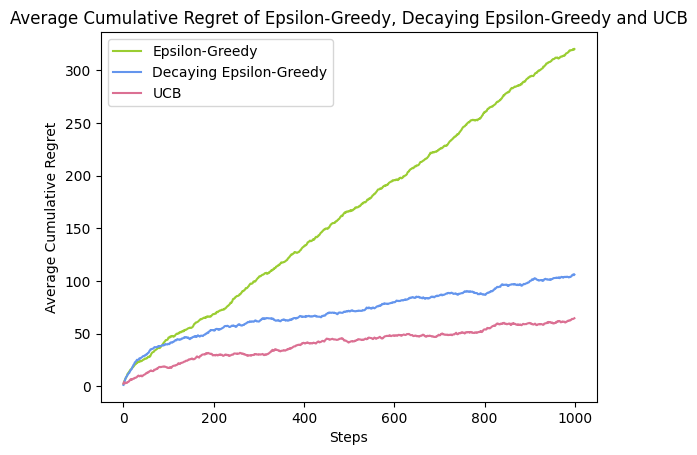

In [22]:
avg_regrets_eps_greedy = np.zeros(steps)
avg_regrets_dec_eps_greedy = np.zeros(steps)
avg_regrets_ucb = np.zeros(steps)

times = 20

for _ in range(times):
    mab1 = Bandits_one()

    _, _, regrets_eps_greedy = epsilon_greedy(mab1, steps, epsilon)
    avg_regrets_eps_greedy += regrets_eps_greedy

    _, _, regrets_dec_eps_greedy = decaying_epsilon_greedy(mab1, steps, epsilon, alpha)
    avg_regrets_dec_eps_greedy += regrets_dec_eps_greedy

    _, _, regrets_ucb = ucb(mab1, steps, c)
    avg_regrets_ucb += regrets_ucb

avg_regrets_eps_greedy /= times
avg_regrets_dec_eps_greedy /= times
avg_regrets_ucb /= times

plt.plot(avg_regrets_eps_greedy, color="yellowgreen", label="Epsilon-Greedy")
plt.plot(avg_regrets_dec_eps_greedy, color="cornflowerblue", label="Decaying Epsilon-Greedy")
plt.plot(avg_regrets_ucb, color="palevioletred", label="UCB")
plt.xlabel("Steps")
plt.ylabel("Average Cumulative Regret")
plt.title("Average Cumulative Regret of Epsilon-Greedy, Decaying Epsilon-Greedy and UCB")
plt.legend()
plt.show()